# First insights on the posts

In this notebook we want to give a look at the content of our data. 
   * First, we focus our analysis on the tags associated with the posts.
* We describe the distribution of those tags, and define the language of a post thanks to its associated tags. 
* We also look at the additional tags with the main languages. 
   * Secondly, we take a look of the date of publications of the posts
* We also consider the activity and commintment around the main languages
   * We also look at the score distribution 
* Again, we compare the score distribution per main languages 
   * Finally, we look at the origins of the users
* We display the number of users per country on a world map


## Preparation

**Imports**

In [1]:
import os
os.chdir(os.environ['HOME'])

import stack_overflow_functions.DataLoader as data_loader
import stack_overflow_functions.DataTransformation as data_transfo
from pycountry_convert import country_name_to_country_alpha3
from pyspark.sql import SparkSession
from pyspark.sql import SparkSession
import patoolib
import gdown

# Import Spark NLP

from sparknlp.base import *
from sparknlp.annotator import *
from pyspark.sql.types import StructField, StructType, StringType

import pyspark
import sparknlp
from pycountry_convert import country_alpha2_to_continent_code, \
    country_name_to_country_alpha2
from geopy.geocoders import Nominatim
import pyspark.sql.functions as F
from pyspark.sql.types import LongType, StringType
import pandas as pd
import re
from wordcloud import WordCloud, STOPWORDS, ImageColorGenerator
import geopandas as gpd
import matplotlib.pyplot as plt
import seaborn as sns
import json
seed = 2020
import warnings
warnings.filterwarnings('ignore')

In [2]:
data_loader.download_data()

All the data folder already exists, we infer that you have already downloaded or extracted the data. If it is not the case delete the data folder (Data/sample) and re run this function.


'Done, data can be found at /home/loic/Data/sample.'

In [3]:
badge_dir = 'Data/sample/Badges'
post_dir = 'Data/sample/Posts'
tags_dir = 'Data/sample/Tags'
users_dir = 'Data/sample/Users'
country_dir = 'Data/sample/Country'

In [4]:
spark = sparknlp.start()
conf = (pyspark
        .SparkConf()
        .set("spark.ui.showConsoleProgress", "true")
        )
sc = pyspark.SparkContext.getOrCreate(conf=conf)
sqlcontext = pyspark.SQLContext(sc)

**Estimates loading time of each tables**

In [5]:
%%time
badges = (sqlcontext.read.format("parquet")
                    .option("header",True)
                    .load(badge_dir))
badges.count()

CPU times: user 11.1 ms, sys: 4.52 ms, total: 15.6 ms
Wall time: 15.8 s


19572945

In [6]:
%%time
tags = (sqlcontext.read.format("parquet")
                  .option("header",True)
                  .load(tags_dir))
tags.count()

CPU times: user 6.47 ms, sys: 2.62 ms, total: 9.09 ms
Wall time: 451 ms


60537

In [7]:
%%time
users = (sqlcontext.read.format("parquet")
                   .option("header",True)
                   .load(users_dir))
users.count()

CPU times: user 8.66 ms, sys: 0 ns, total: 8.66 ms
Wall time: 9.39 s


1071921

In [8]:
%%time
posts = (sqlcontext.read.format("parquet")
                   .option("header",True)
                   .load(post_dir)
                   .sample(False,0.2,seed))
posts.cache().count()

CPU times: user 19 ms, sys: 2.4 ms, total: 21.4 ms
Wall time: 2min 5s


418355

In [9]:
%%time
country = (sqlcontext.read.format("parquet")
                     .option("header",True)
                     .load(country_dir))
country.count()

CPU times: user 4.57 ms, sys: 1.83 ms, total: 6.4 ms
Wall time: 392 ms


42500

### Clean the posts questions and tags

We are using here only 20% of the posts dataset in order to get some first insights on its content. 

In [10]:
# Tags split 
tags_split = F.regexp_replace(
                F.regexp_replace(
                    F.regexp_replace(F.col('Tags'), '&lt;', ''),
                                     "&gt;", "<split_token>"),
                                     " ", ""
                              )

udf_drop = F.udf(lambda x: re.sub("'","",str(x[:-1])[1:-1])\
                 if isinstance(x,list) else None)

In [11]:
# Applying our transformation

cleaned_post = (
    posts
    .withColumn('Splitted_tags', tags_split)
    .withColumn('Splitted_tags', F.split(F.col("Splitted_tags"),"<split_token>"))
    .withColumn('Splitted_tags', udf_drop(F.col("Splitted_tags")))
    .withColumn('Splitted_tags', F.split(F.col("Splitted_tags"),","))
    .drop('Tags')
    )

## 1 - Tags Analysis

In this part, we will analyse the different tags and their meaning. We will try to implement a rule in order to detect the language asked about in the posts. We will also observe the behavior of the tags between them. 

**Get all the tags of the posts**

In [12]:
tags = (cleaned_post
        .select(F.explode('Splitted_tags').alias("tags"))
        .select(F.trim("tags").alias("tags"))
        .groupBy('tags')
        .count()
       ).toPandas()
count_posts = cleaned_post.count()

In [13]:
print('There are {} distinct tags'.format(tags.shape[0]))

There are 33588 distinct tags


**Distribution of the tags overall**

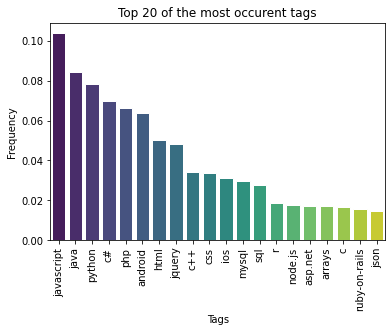

In [14]:
sns.set_palette("viridis")
top = 20
options = {
    "title" : "Top {} of the most occurent tags".format(top),
    "xlabel": "Tags",
    "ylabel": "Frequency"
}

tmp = tags.sort_values(by ="count",ascending = False).head(top)
tmp["count"] = tmp["count"] / count_posts

fig, ax = plt.subplots(1);
sns.set_style('whitegrid');
sns.barplot(x="tags", y="count", data=tmp, ax=ax, palette = 'viridis')
ax.set(**options);
plt.xticks(rotation=90);

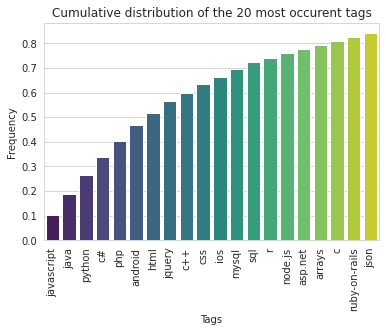

In [15]:
options = {
    "title" : "Cumulative distribution of the {} most occurent tags".format(top),
    "xlabel": "Tags",
    "ylabel": "Frequency"
}

tmp2 = tags.sort_values(by ="count",ascending = False).head(top)
tmp2["count"] = tmp2["count"] / count_posts
tmp2['cum'] = tmp2['count'].cumsum()


fig, ax = plt.subplots(1);
sns.set_style('whitegrid');

sns.barplot(data = tmp2, x='tags', y ='cum',ax=ax, palette = 'viridis')
ax.set(**options);
plt.xticks(rotation=90);

The most occurent tag is Javascript as more than 10% of posts tagged it.
We also observe that 14 languages are composing more than 50% of the posts. We notice that the cumulative distribution of the activity per language is logarithmic : the differences in commintment between languages become lower as their activity is increasing.

**Tags into languages**

We don't have access to the language a post is about. We will consider as languages the most occurent tags we saw above. We consider that the first tag of a post is the most relevant, and thus we set a rule that say that the first tag corresponding to a language is the language the post is talking about. 

In [16]:
deduced_languages = tmp['tags']
cleaned_post = (
    cleaned_post
    .withColumn('language_deduced',
                data_transfo.udf_detect_language(deduced_languages)(F.col('Splitted_tags'))))

In [17]:
languages = (
    cleaned_post
    .select("Id", 
            F.explode('Splitted_tags').alias("tags"),
            "language_deduced"
           )
    .filter(F.col("language_deduced") != F.col("tags") )
    .groupBy('language_deduced','tags')
    .count()
    .toPandas()
)

We are also interested in the other tags accompanying the deduced language. 

Text(0.5, 1.01, 'Most frequent tags assciated with the deduced languages')

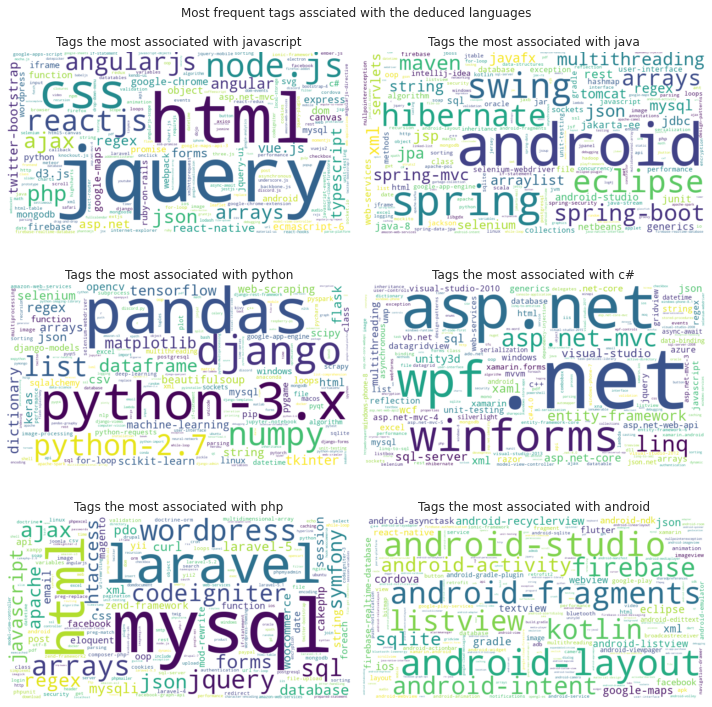

In [18]:
top = 6 
lang_to_plot = deduced_languages.iloc[:top]
wc = WordCloud(background_color='white', width=750, height=400)

fig, ax = plt.subplots(top//2, 2, figsize =(10,10))
i=0
j=0
for lang in lang_to_plot:
    tmp = (languages
           .loc[languages['language_deduced'] == lang,
                ['tags', 'count']]
           .set_index('tags')
           ).to_dict()['count']
    wc.fit_words(tmp)
    ax[i, j].imshow(wc, interpolation='bilinear')
    ax[i, j].axis("off")
    ax[i, j].set_title("Tags the most associated with {}".format(lang))
    if j==1:
        j=0
        i+=1
    else:
        j+=1
plt.tight_layout()
plt.suptitle("Most frequent tags assciated with the deduced languages", y = 1.01)

We find that the tags associated with each languages are very differents. This informs us that the tags are not independant from one another. The tags seem to behave in cluster, as they tends to appears in distinct groups of labels. The deduced language appears to narow the set of other possible tags.  


### 2 - Dates of the posts

In this part, we will analyse the date of publication. We will try to observe the number of publication by week on all posts, and also the activity according to the main languages.

**Date over all Stack Overflow**

In [19]:
# We get all the dates 
cleaned_post = (
    cleaned_post
    .withColumn("CreationDate",
                F.to_timestamp(F.regexp_replace(F.col("CreationDate"),"T"," "),
                                "yyyy-MM-dd HH:mm:ss.SSS")
                 .alias("CreationDate"))
)

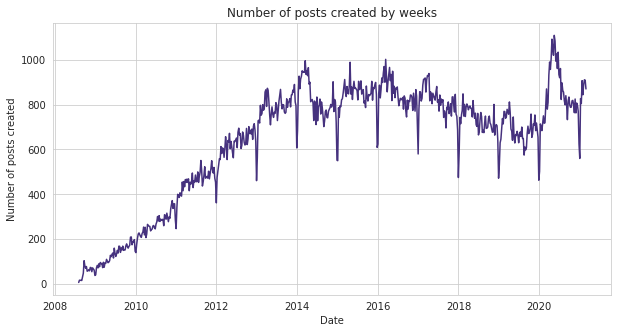

In [38]:
time = (
    cleaned_post
    .select(F.to_date("CreationDate").alias('date'))
    .groupBy('date')
    .count()
).toPandas()


options = {
    "title" : "Number of posts created by weeks",
    "xlabel": "Date",
    "ylabel": "Number of posts created"
}

fig = plt.figure(figsize=[10,5]);
time['date'] = time['date'].astype('datetime64');
time = time.set_index('date').resample("1W").sum();


ax = sns.lineplot(x='date', y='count', data=time, palette='viridis');
ax.set(**options);

The activity over all stack overflow increased linearly until 2014 and then nearly stabilized on a plateau before encountering a peak little after 2020.  

**Dates per main languages**

In [21]:
time_pertag = (
    cleaned_post
    .select(F.to_date("CreationDate").alias('date'),'language_deduced')
    .groupBy('language_deduced','date')
    .count()
).toPandas()
time_pertag['date'] = time_pertag['date'].astype('datetime64')
time2 = (
    time_pertag
    .set_index('date')
    .groupby([pd.Grouper(freq='1M'), 'language_deduced'])
    .sum()
    .reset_index())

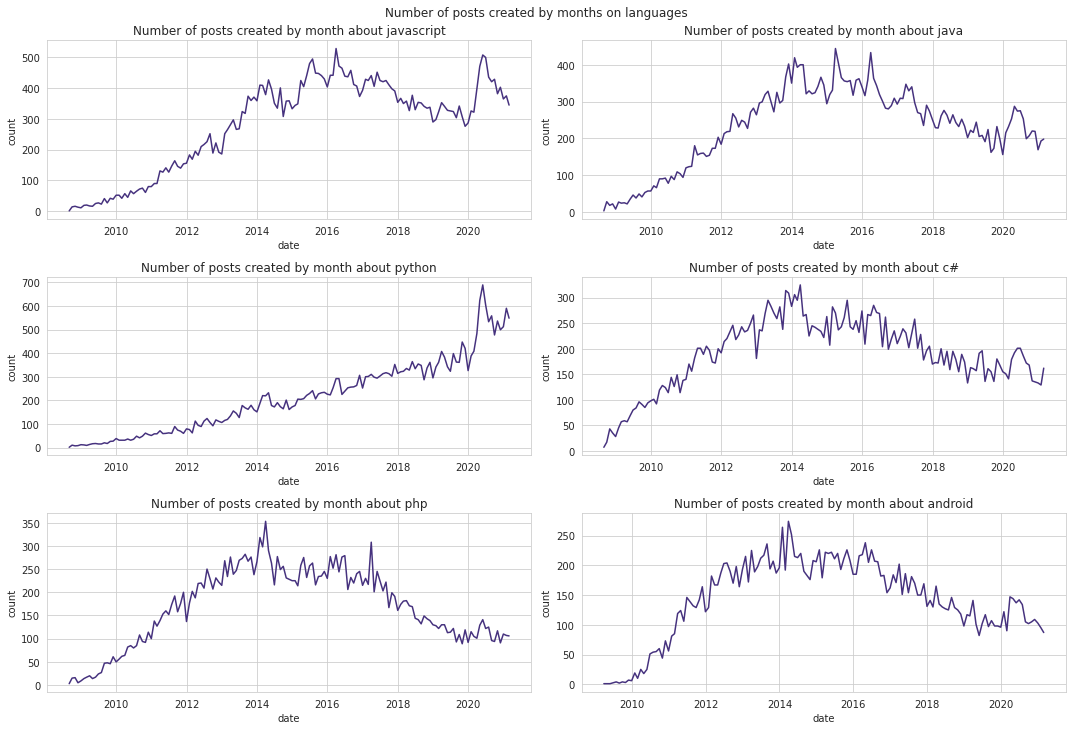

In [39]:
fig, ax = plt.subplots(top//2, 2, figsize =(15,10))
i=0
j=0
c=0
for lang in lang_to_plot:
    tmp = time2[time2['language_deduced']==lang]
    ax[i, j].set_title("Number of posts created by month about {}".format(lang))
    sns.lineplot(x='date', y='count', data=tmp, ax=ax[i,j], palette='viridis')
    if j==1:
        j=0
        i+=1
    else:
        j+=1
    c+=1
plt.tight_layout();
plt.suptitle("Number of posts created by months on languages", y = 1.01);

We can see that the behavior of the number of publications per month are drastically differents among the 6 most used languages. We observe bell-shaped graphs for the php, android c# and java languages : with a peak around 2014 for php, android and java, and aroud 2015 for c#.

The activity around javascript seems to have followed the same path as the overall activity described before. As this is the main language on the platform, this results makes sense. 
 
Python activty seems to be increasing almost linearly, and peaked just after 2020.

Those shapes can be explained by the languages life span and the updates on them : when a language is new, a lot of issues and questions can appear, and on in the opposite, as a language is aging, the number of unasked questions is decreasing. When a language is constantly evolving, the activity around it will increase. 

As we saw previously, the first activity increase before 2014 is common to every tags, and was probably growing with the platform. The evolution after that falls under the subject of the commintment around the different languages. And all languages get an increased in activity during the lockdown. 

### 3 - Scores distributions

In this part, we will analyse the distribution of the scores. We will also look at the distribution of scores of each languages. 

Text(0.5, 1.0, 'Boxplot')

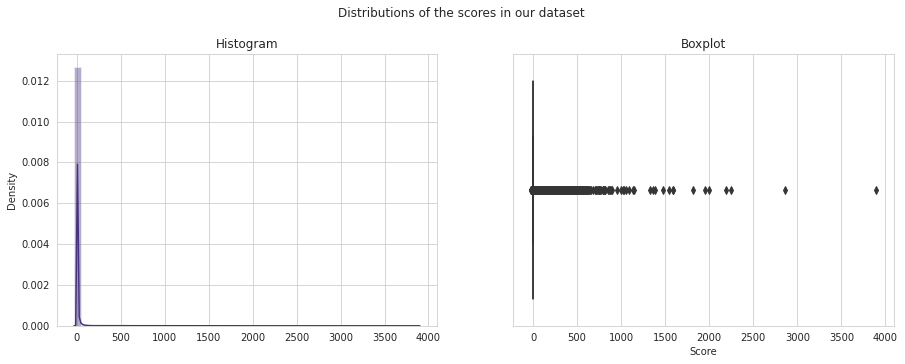

In [23]:
scores = (
    cleaned_post
    .select(F.col('Score').cast("int"))
    .toPandas()
)

fig, ax = plt.subplots(1,2,figsize =[15,5])
plt.suptitle("Distributions of the scores in our dataset", y =1.01)
sns.distplot(scores,  ax=ax[0], kde=True)
ax[0].set_title("Histogram")


sns.boxplot(scores["Score"], ax=ax[1], orient = 'h')
ax[1].set_title("Boxplot")


In [24]:
scores.describe().style.set_caption('Descriptive statistics of the scores')

,Score
count,418355.000000
mean,2.105081
std,18.423831
min,-28.000000
25%,0.000000
50%,0.000000
75%,1.000000
max,3898.000000


As we can see, a majority of the posts get a score of 0 and the volatility of the scores is low. We notice that there are some very high scores, but there are only few of them. 

**Score per language**

In [25]:
def color_max(s):
    '''
    color the maximum in a Series red.
    '''
    is_max = s == s.max()
    return ['color: red' if v else '' for v in is_max]

def color_min(s):
    '''
    color the minimum in a Series blue.
    '''
    is_min = s == s.min()
    return ['color: blue' if v else '' for v in is_min]

We will show below the min max an average scores per group. 

In [26]:
scores_pertag= (
    cleaned_post
    .select(F.col('Score').cast("int"),'language_deduced')
    .toPandas()
)
score_pertag = scores_pertag.loc[scores_pertag['language_deduced'].isin(lang_to_plot)]

In [27]:
(score_pertag
     .groupby('language_deduced', as_index=False)['Score']
     .min()
     .rename(columns={'language_deduced' : 'language',
                      'Score' : 'Min score'})
     .style.set_caption('Min score among language')
     .apply(color_max,subset=['Min score'])
     .apply(color_min,subset=['Min score']))

,language,Min score
0,android,-11
1,c#,-14
2,java,-22
3,javascript,-14
4,php,-16
5,python,-13


In [28]:
(score_pertag
     .groupby('language_deduced', as_index=False)['Score']
     .mean()
     .rename(columns={'language_deduced' : 'language',
                      'Score' : 'Mean score'})
     .style.set_caption('Mean score among language')
     .apply(color_max,subset=['Mean score'])
     .apply(color_min,subset=['Mean score']))

,language,Mean score
0,android,2.593543
1,c#,2.259201
2,java,2.335740
3,javascript,1.993839
4,php,1.183678
5,python,2.150340


In [29]:
(score_pertag
     .groupby('language_deduced', as_index=False)['Score']
     .max()
     .rename(columns={'language_deduced' : 'language',
                      'Score' : 'Max score'})
     .style.set_caption('Max score among language')
     .apply(color_max,subset=['Max score'])
     .apply(color_min,subset=['Max score']))

,language,Max score
0,android,2864
1,c#,1360
2,java,3898
3,javascript,1812
4,php,466
5,python,1055


We choose to observe the mean score for each languages. If we took the median, we will only get 0 as a majority of posts get a null score. To get more info than that, we decide to look at the mean score. 

Php has the lowest mean and max score.
Java is where the highest score appears, but also the lowest. Even with such a high score, the highest mean score goes to android.

### 4 - Users 

In this part, we will analyse the origins of the users.  

In [30]:
users.cache().count()

1071921

In [31]:
def country_name_to_ISO3(country):
    """
    Transforms country name into country ISO3 format
    """
    try:
        cn_a2_code =  country_name_to_country_alpha3(country)
    except:
        cn_a2_code = None
    return(cn_a2_code)

We count all the users by their country. 

In [32]:
users_by_country = (
    users
    .select("Id","Location","Reputation")
    .join(country, on=['Location'], how='left')
    .groupby('Country')
    .count()).toPandas()

users_by_country["country_code"] = (users_by_country["Country"]
                                    .apply(country_name_to_ISO3))

gdf = data_loader.get_country_polygon()[[ 'ADM0_A3', 'geometry']]
gdf.columns = ['country_code', 'geometry']
users_by_country = (gdf.merge(users_by_country,
                             on = "country_code",how = "left")
                    .fillna({'count':0,'Country':'N/A'}))
users_by_country.head()

,country_code,geometry,Country,count
0,FJI,"MULTIPOLYGON (((180.00000 -16.06713, 180.00000...",Fiji,19.0
1,TZA,"POLYGON ((33.90371 -0.95000, 34.07262 -1.05982...",Tanzania,116.0
2,SAH,"POLYGON ((-8.66559 27.65643, -8.66512 27.58948...",N/A,0.0
3,CAN,"MULTIPOLYGON (((-122.84000 49.00000, -122.9742...",Canada,13750.0
4,USA,"MULTIPOLYGON (((-122.84000 49.00000, -120.0000...",United States,84923.0


In [33]:
merged_json = json.loads(users_by_country.to_json())
json_data = json.dumps(merged_json)

We display on a world map the number of users per coutry. 

In [34]:
from bokeh.io import output_notebook, show, output_file
p = data_transfo.plot_map(json_data,
                          "Posts users number according to the country.",
                          "count",0,10000,
                          palette_name='YlGnBu',n_colors=9)
show(p)

Loading BokehJS ...

We can see that stackoverflow is mainly used in north America, some countries of west Europe and India and we notice that only few users come from Africa. In south America, Bresil has a very active population similar as Russia. We can also point at Australia, which is also pretty active 